HERE IS HELP!!

https://drivendata.co/blog/tick-tick-bloom-benchmark

In [1]:
import pandas as pd
import geopandas as gp
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer


import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
meta_df = pd.read_csv('driven_data_HAB/metadata.csv')

In [5]:
meta_df

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train
...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test
23566,zzwo,39.792190,-99.971050,2017-06-19,train
23567,zzwq,35.794000,-79.012551,2015-03-24,train
23568,zzyb,35.742000,-79.238600,2016-11-21,train


In [12]:
lat_list = list(meta_df['latitude'])
long_list = list(meta_df['longitude'])

In [13]:
lat_list, long_list

([39.0803190688889,
  36.5597,
  35.8750832404158,
  35.486999999999995,
  38.04947082,
  39.474744,
  35.647742474341605,
  35.90688526381,
  35.726521939921,
  35.98,
  35.8613251384981,
  35.8962328282395,
  33.0426,
  37.74668,
  40.703967999999996,
  38.9725,
  34.279,
  37.9718,
  40.43393,
  38.0201,
  35.79,
  33.8892,
  37.3906,
  35.9075374537429,
  39.820322999999995,
  38.691,
  36.6519,
  36.115,
  39.90293,
  35.703553467355,
  36.313,
  40.82201,
  34.41,
  41.292491999999996,
  35.7229289575381,
  34.446,
  37.2486,
  39.12106,
  35.6822351052168,
  37.6003,
  35.7154236165606,
  37.4583,
  38.0505,
  36.9818,
  35.7589,
  35.48,
  35.976,
  35.888158095737,
  39.7533,
  34.6721,
  35.858033132170206,
  48.97325,
  42.056765999999996,
  34.9454,
  36.7962,
  38.1156,
  41.72506,
  36.3708,
  35.8952700716719,
  44.761666999999996,
  35.6954359886381,
  37.8717,
  41.890646000000004,
  35.433,
  42.086392,
  35.6500313371928,
  36.9128,
  44.736667,
  37.1366,
  41.69332

In [14]:
lat_long = list(zip(lat_list, long_list))

In [18]:
lat_long_list = []
for x in lat_long:
    lat_long_list.append(list(x))

In [30]:
len(lat_long_list)

23570

In [34]:
lat_long_list

[[39.0803190688889, -86.4308666666667],
 [36.5597, -121.51],
 [35.8750832404158, -78.8784342810571],
 [35.486999999999995, -79.06213295800029],
 [38.04947082, -99.82700111],
 [39.474744, -86.898353],
 [35.647742474341605, -79.2717820986074],
 [35.90688526381, -79.13296162642959],
 [35.726521939921, -79.12545777505241],
 [35.98, -78.7916861916675],
 [35.8613251384981, -78.7683213767603],
 [35.8962328282395, -79.0477049082042],
 [33.0426, -117.07600000000001],
 [37.74668, -97.77936],
 [40.703967999999996, -80.29305],
 [38.9725, -94.67293000000001],
 [34.279, -118.905],
 [37.9718, -121.374],
 [40.43393, -105.0334],
 [38.0201, -122.259],
 [35.79, -79.02639225329409],
 [33.8892, -117.56200000000001],
 [37.3906, -120.958],
 [35.9075374537429, -79.13818142550458],
 [39.820322999999995, -79.921575],
 [38.691, -100.92399999999999],
 [36.6519, -120.632],
 [36.115, -78.9087588280644],
 [39.90293, -75.18015],
 [35.703553467355, -79.1681192247916],
 [36.313, -79.1149777897167],
 [40.82201, -77.4699

In [35]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        lat_long_list[:50]
    ],
}

In [38]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-148.56536865234375, 60.80072385643073],
            [-147.44338989257812, 60.80072385643073],
            [-147.44338989257812, 61.18363894915102],
            [-148.56536865234375, 61.18363894915102],
            [-148.56536865234375, 60.80072385643073],
        ]
    ],
}

In [39]:
time_of_interest = "2019-06-01/2019-08-01"

In [60]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 5 Items


In [42]:
items

ID: S2B_MSIL2A_20190801T213539_R086_T06VVN_20201004T192210
"Bounding Box: [-148.86876, 60.60503400976997, -148.2243, 61.32559057515295]"
Datetime: 2019-08-01 21:35:39.024000+00:00
datetime: 2019-08-01T21:35:39.024000Z
platform: Sentinel-2B
proj:epsg: 32606
instruments: ['msi']
s2:mgrs_tile: 06VVN
constellation: Sentinel 2
s2:granule_id: S2B_OPER_MSI_L2A_TL_ESRI_20201004T192211_A012553_T06VVN_N02.12
eo:cloud_cover: 64.778988


In [43]:
least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

Choosing S2B_MSIL2A_20190629T212529_R043_T06VVN_20201006T080531 from 2019-06-29 with 0.314306% cloud cover


In [44]:
asset_href = least_cloudy_item.assets["visual"].href


In [57]:
len(items)

37

In [61]:
asset_list = []
for x in range(len(items)):
    asset_list.append(items[x].assets["visual"].href)


In [62]:
asset_list

['https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/06/V/VN/2019/07/17/S2A_MSIL2A_20190717T213531_N0212_R086_T06VVN_20201005T152616.SAFE/GRANULE/L2A_T06VVN_A021247_20190717T213556/IMG_DATA/R10m/T06VVN_20190717T213531_TCI_10m.tif?st=2023-01-08T19%3A56%3A09Z&se=2023-01-09T20%3A41%3A09Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-01-09T18%3A45%3A03Z&ske=2023-01-16T18%3A45%3A03Z&sks=b&skv=2021-06-08&sig=y8HAUv5xa6J/0f20BF1Zon6S5LkdKSJ90OUd2V%2BwHsY%3D',
 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/06/V/VN/2019/07/07/S2A_MSIL2A_20190707T213531_N0212_R086_T06VVN_20201005T103624.SAFE/GRANULE/L2A_T06VVN_A021104_20190707T213534/IMG_DATA/R10m/T06VVN_20190707T213531_TCI_10m.tif?st=2023-01-08T19%3A56%3A09Z&se=2023-01-09T20%3A41%3A09Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-01-09T18%3A45%3A03Z&ske=2023-01-16T18%3A45%3A03Z&

In [64]:
pic_list = []

for x in range(len(asset_list)):
    with rasterio.open(asset_list[x]) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        band_data = ds.read(window=aoi_window)
        pic_list.append(band_data)

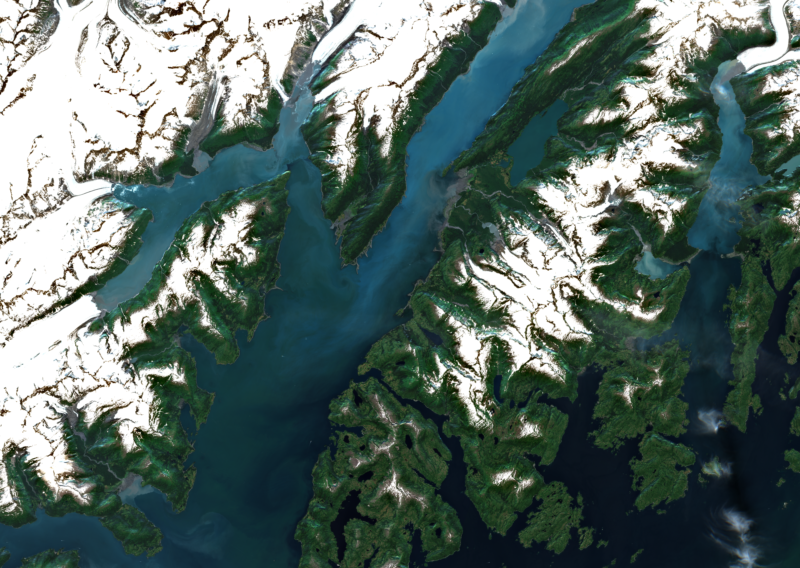

In [71]:
img = Image.fromarray(np.transpose(pic_list[2], axes=[1, 2, 0]))
w = img.size[0]
h = img.size[1]
aspect = w / h
target_w = 800
target_h = (int)(target_w / aspect)
img.resize((target_w, target_h), Image.BILINEAR)

In [5]:
df = pd.read_csv('timeseries-global/timeseries_global.csv')

In [6]:
df

,GRIDCODE,EEZ,Country,Sovereign,Region,x1998,x1999,x2000,x2001,x2002,x2003,x2004,x2005,x2006,x2007,SLOPE,R2,CHANGE,SCHANGE,p
0,920439,Alaskan Exclusive Economic Zone,Alaska,United States,Northern America,2.195129,0.913217,0.775293,0.591110,0.393235,0.276987,0.618238,0.938439,1.829810,1.105238,-0.015830,0.006116,-0.261395,-999999.000000,n.s.
1,920440,Alaskan Exclusive Economic Zone,Alaska,United States,Northern America,2.195129,0.913217,0.775293,0.591110,0.393235,0.276987,0.618238,0.938439,1.829810,1.105238,-0.015830,0.006116,-0.261395,-999999.000000,n.s.
2,920441,Alaskan Exclusive Economic Zone,Alaska,United States,Northern America,2.195129,0.913217,0.775293,0.591110,0.393235,0.276987,0.618238,0.938439,1.829810,1.105238,-0.015830,0.006116,-0.261395,-999999.000000,n.s.
3,924756,Alaskan Exclusive Economic Zone,Alaska,United States,Northern America,1.737873,0.684740,0.672416,21.331726,0.363391,0.270806,0.591267,0.373777,2.337018,0.820461,-0.366654,0.029137,14.094407,-999999.000000,n.s.
4,924757,Alaskan Exclusive Economic Zone,Alaska,United States,Northern America,1.737873,0.684740,0.672416,21.331726,0.363391,0.270806,0.591267,0.373777,2.337018,0.820461,-0.366654,0.029137,14.094407,-999999.000000,n.s.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439075,4072247,Yemeni Exclusive Economic Zone,Yemen,Yemen,Asia,0.540588,0.668298,0.437458,0.493197,0.575453,0.412548,0.545446,0.438393,0.472563,0.395394,-0.016232,0.335551,-20.651363,-999999.000000,n.s.
439076,4072248,Yemeni Exclusive Economic Zone,Yemen,Yemen,Asia,0.483738,0.707705,0.486394,0.501834,0.490569,0.387086,0.532348,0.414204,0.456071,0.396134,-0.017714,0.342928,-24.521345,-999999.000000,n.s.
439077,4072249,Yemeni Exclusive Economic Zone,Yemen,Yemen,Asia,0.541238,0.696546,0.505669,0.510282,0.430273,0.395447,0.542685,0.386002,0.430273,0.407510,-0.021839,0.479131,-29.806806,-29.806806,<0.05
439078,4072250,Yemeni Exclusive Economic Zone,Yemen,Yemen,Asia,0.525427,0.801937,0.478597,0.490045,0.422077,0.392448,0.632942,0.416979,0.449000,0.375528,-0.022598,0.275999,-31.255060,-999999.000000,n.s.


In [7]:
plankton = gp.read_file('timeseries-global/timeseries_global.csv')

In [10]:
plankton = plankton.set_crs("EPSG:4326")

In [11]:
plankton.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
ax = plankton.plot()

C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\geopandas\array.py:938: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\geopandas\array.py:939: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\geopandas\array.py:940: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\geopandas\array.py:941: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

ModuleNotFoundError: No module named 'pystac'